In [2]:
import gym

env = gym.make("MsPacman-v0")
obs = env.reset()

[2017-06-11 15:30:03,174] Making new env: MsPacman-v0


In [3]:
obs.shape

(210, 160, 3)

In [4]:
env.action_space

Discrete(9)

In [19]:
import numpy as np
mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.mean(axis=2)
    img[img==mspacman_color] = 0
    img = (img - 128) / 128 - 1
    return img.reshape(88, 80, 1)


In [24]:
import tensorflow as tf 
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [25]:

reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"]*3 
conv_activation = [tf.nn.relu]*3
n_hidden_inputs = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01

def q_network(X_state, scope):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, kernel_initializer=initializer)
            conv_layers.append(prev_layer)
        print(prev_layer.shape)    
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_inputs])
        print(last_conv_layer_flat.shape)    
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation=hidden_activation, kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs)
    trainable_vars = {var.name[len(scope.name):]: var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
    return outputs, trainable_vars

In [27]:
# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



<IPython.core.display.Javascript object>


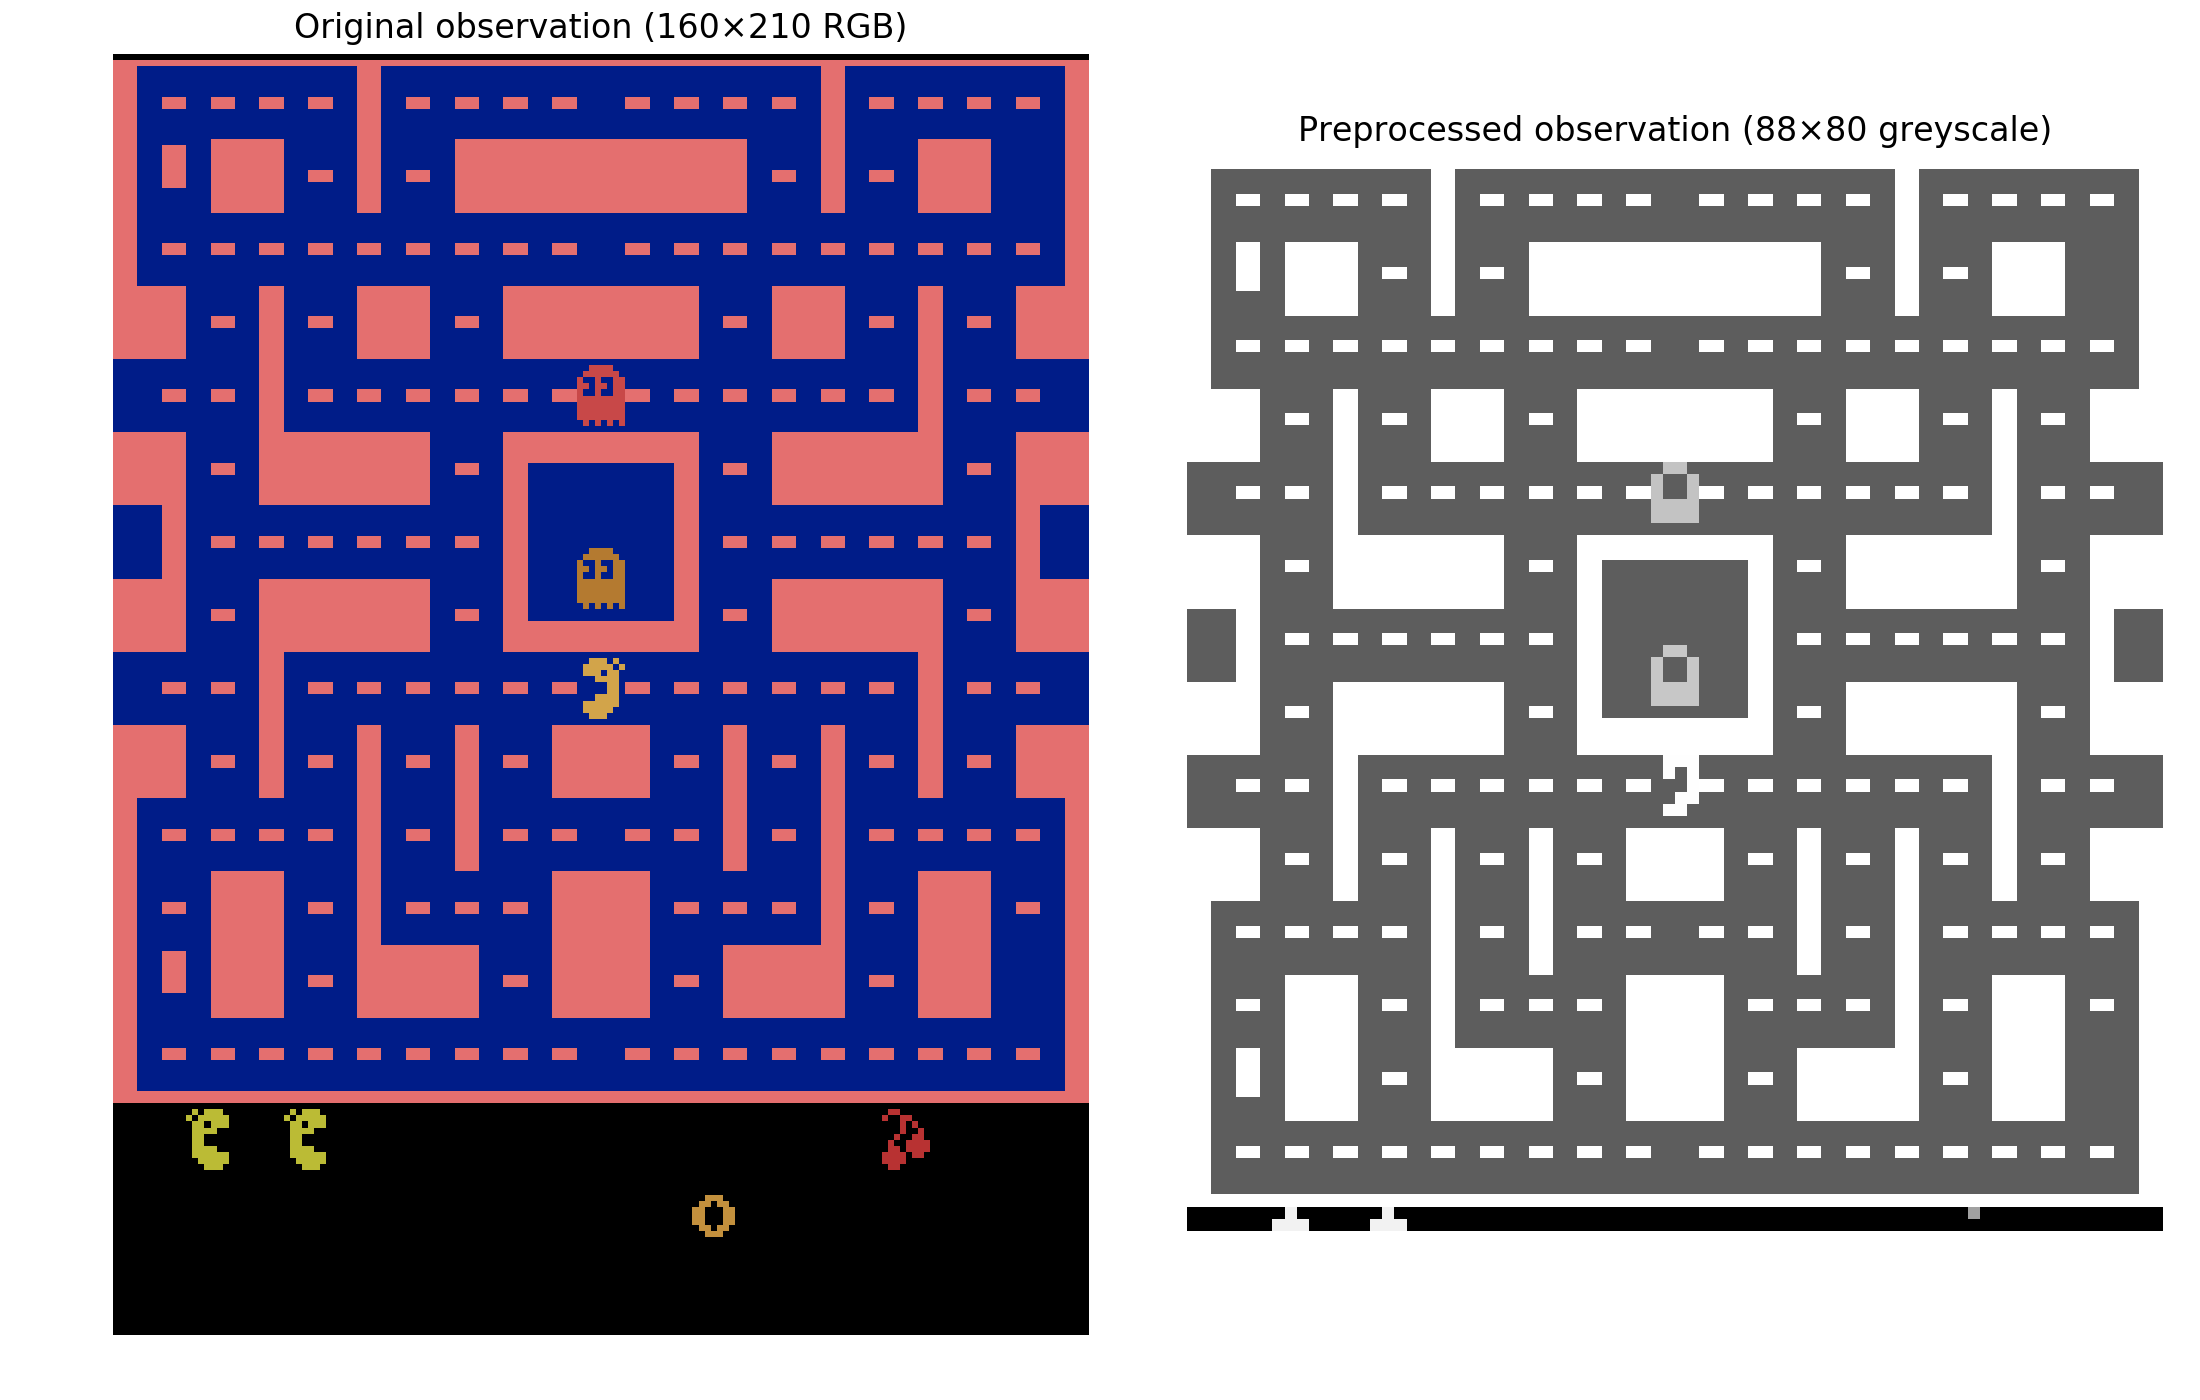

Saving figure preprocessing_plot


In [32]:
import os
import sys

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

In [33]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
actor_q_values, actor_vars = q_network(X_state, scope="q_networks/actor")    # acts
critic_q_values, critic_vars = q_network(X_state, scope="q_networks/critic") # learns

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

(?, 11, 10, 64)
(?, 7040)
(?, 11, 10, 64)
(?, 7040)


In [34]:

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    cost = tf.reduce_mean(tf.square(y - q_value))
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()



In [36]:
from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [37]:

eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000
import sys

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [39]:
n_steps = 100000  # total number of training steps
training_start = 1000  # start training after 1,000 game iterations
training_interval = 3  # run a training step every 3 game iterations
save_steps = 50  # save the model every 50 training steps
copy_steps = 25  # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

from numpy import random as rnd

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f}%)".format(iteration, step, n_steps, step * 100 / n_steps), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Actor plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        y_val = rewards + continues * discount_rate * np.max(next_q_values, axis=1, keepdims=True)
        training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy critic to actor
        if step % copy_steps == 0:
            copy_critic_to_actor.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 300999	Training step 99999/100000 (100.0%)